In [1]:
#mount google drive when on google colaboratory

from google.colab import drive
drive.mount('/content/drive')

#set repo path and check repo status
repo_path = '/content/drive/MyDrive/geomsha/'
%cd /content/drive/MyDrive/geomsha/
!git status


Mounted at /content/drive
/content/drive/MyDrive/geomsha
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [4]:
#initialize environment, load modules/libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#import python code from seperate files
from utils.generators import gen_shapes, gen_noise, gen_image, gen_details
from utils.helpers import gen_grid_image

rnd=np.random.default_rng(31)


In [32]:
folder=["train","validate","test"] 
num_images={"train":10, "validate":5, "test":2}

num_shapes=50
max_radius=1/20
min_radius=1/40

num_noise=500
max_line=1/10
min_line=1/80

im_size=1024
max_lw=0.5
min_lw=0.1
min_gray=0.7

radius = int(max_radius*im_size)+1
detail_im_size = 2*radius+1

fluct=0

In [33]:
for name in folder:
    for i in range(num_images[name]):
        shapes = gen_shapes(rnd, num_shapes, max_radius, min_radius, False, False)
        noise = gen_noise(rnd, num_noise, max_line, min_line)
        img, sha, nse, box = gen_image(shapes, noise, rnd, im_size, max_lw, min_lw, min_gray, False)
        focus = gen_details(detail_im_size, sha, img, rnd, fluct)

        target = name+"/"+name+f"{i:04d}"
        np.savez_compressed("data/"+target+".npz", image=img, shapes=sha, details=focus, boxes=box)

    plt.close()

In [34]:
for name in folder:
    for i in range(num_images[name]):
        source = name+"/"+name+f"{i:04d}"
        loaded  = np.load("data/"+source+".npz")
        image = loaded['image']
        shapes = loaded['shapes']
        details = loaded['details']
        boxes = loaded['boxes']

        fig = plt.figure(figsize=(image.shape[1],image.shape[0]),dpi=1)
        fig.figimage(image, cmap='gray')
        fig.savefig("data/"+source+".jpg")
        plt.close()


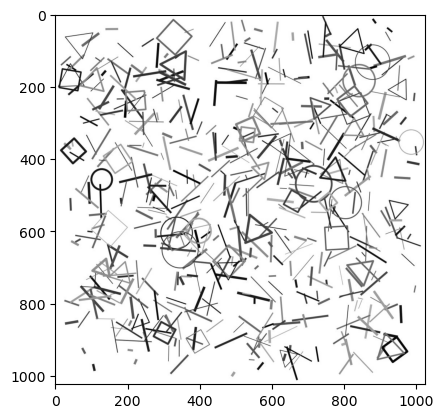

In [35]:
plt.imshow(mpimg.imread("data/"+source+".jpg"))

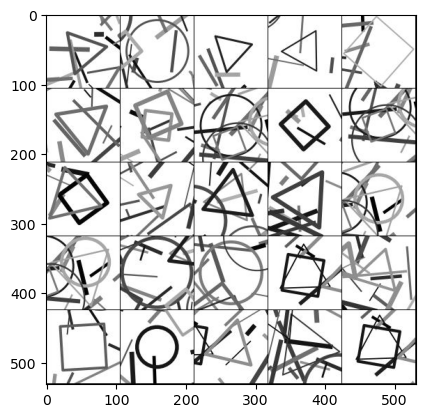

In [36]:
grid = (5,5)
grid_image, grid_pos = gen_grid_image(details, grid)

fig = plt.figure(figsize=(grid_image.shape[1],grid_image.shape[0]),dpi=1)
fig.figimage(grid_image, cmap='gray')
fig.savefig('data/tmp_grid.jpg')
plt.close()

plt.imshow(mpimg.imread('data/tmp_grid.jpg'))

In [37]:
print("\nposition : shape : [pos_x, pos_y, size, rotation, line_width]")
np.set_printoptions(precision=3, suppress=True)
for i in range(grid[0]*grid[1]):
    print(f"{grid_pos[i]} : {int(shapes[i][0])} {shapes[i][1:]}")


position : shape : [pos_x, pos_y, size, rotation, line_width]
(0, 0) : 3 [729.107 765.753  34.571   0.706   0.31 ]
(0, 1) : 2 [803.91  501.869  44.381   0.      0.208]
(0, 2) : 3 [947.975 486.998  31.085   0.828   0.213]
(0, 3) : 3 [955.214 814.806  33.202   1.587   0.149]
(0, 4) : 4 [150.502 430.4    50.217   0.062   0.142]
(1, 0) : 3 [847.809 313.852  42.221   1.204   0.365]
(1, 1) : 4 [532.39  690.081  27.098   0.66    0.338]
(1, 2) : 2 [336.615 418.029  43.697   0.      0.2  ]
(1, 3) : 4 [ 51.301 645.21   34.52    1.522   0.42 ]
(1, 4) : 4 [334.613 392.234  25.923   1.145   0.194]
(2, 0) : 4 [940.371  95.564  34.921   1.412   0.438]
(2, 1) : 3 [571.824 593.007  27.718   1.319   0.355]
(2, 2) : 3 [773.154 585.967  38.833   1.693   0.189]
(2, 3) : 3 [337.34  882.401  45.694   1.517   0.433]
(2, 4) : 2 [397.644 423.892  34.216   0.      0.332]
(3, 0) : 3 [394.525 408.539  49.165   1.273   0.167]
(3, 1) : 2 [716.041 553.948  49.796   0.      0.351]
(3, 2) : 2 [841.533 839.558  44.338 

In [38]:
print("\nposition : [x_min, x_max, y_min, y_max]")
np.set_printoptions(precision=3, suppress=True)
for i in range(grid[0]*grid[1]):
    print(f"{grid_pos[i]} : {boxes[i]}")


position : [x_min, x_max, y_min, y_max]
(0, 0) : [706.687 763.107 733.178 792.068]
(0, 1) : [759.529 848.291 457.488 546.25 ]
(0, 2) : [925.073 977.628 456.656 508.017]
(0, 3) : [922.017 972.283 786.327 843.827]
(0, 4) : [100.383 200.622 380.281 480.52 ]
(1, 0) : [808.397 880.629 272.149 340.412]
(1, 1) : [510.983 553.796 668.674 711.487]
(1, 2) : [292.918 380.312 374.332 461.726]
(1, 3) : [ 16.821  85.78  610.731 679.689]
(1, 4) : [311.01  358.216 368.631 415.837]
(2, 0) : [905.89  974.852  61.084 130.045]
(2, 1) : [544.98  591.226 566.307 612.802]
(2, 2) : [734.608 796.51  554.942 621.706]
(2, 3) : [291.712 362.267 841.666 920.697]
(2, 4) : [363.427 431.86  389.676 458.109]
(3, 0) : [347.53  430.533 360.617 442.015]
(3, 1) : [666.245 765.837 504.152 603.745]
(3, 2) : [797.196 885.871 795.22  883.895]
(3, 3) : [  9.093  80.753 823.43  886.726]
(3, 4) : [149.628 208.052 278.937 338.478]
(4, 0) : [746.479 812.946 370.796 437.264]
(4, 1) : [100.67  157.957 537.396 594.683]
(4, 2) : [ 69